In [21]:
import numpy as np
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.image as mpimg


In [22]:
# Connect to the Coppeliasim API
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(False)


0

In [23]:
robot_path = '/PioneerP3DX'
robot_handle = sim.getObject('/PioneerP3DX')

goal_handle = sim.getObject('/ReferenceFrame')

rmotor = sim.getObject(robot_path + '/rightMotor')
lmotor = sim.getObject(robot_path + '/leftMotor')

sensors = []
for i in range(16):
    sensors.append(sim.getObject(robot_path + f'/ultrasonicSensor[{i}]'))

## Campos Potenciais
Implementação de campos potenciais para **robô diferencial**.

(500, 500)

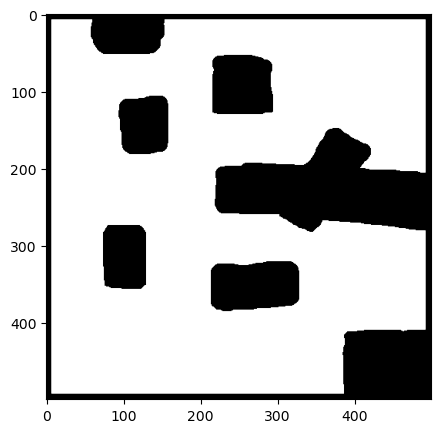

In [24]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# source_img = mpimg.imread('img/walls.png')
source_img = mpimg.imread('img/cave.png')

source_img = source_img.copy()

threshold = 0.5
source_img[source_img >= threshold] = 1
source_img[source_img < threshold] = 0

ax.imshow(source_img, cmap='Greys', origin='upper')
source_img.shape

In [25]:
# Start simulation
sim.startSimulation()

sim.setJointTargetVelocity(rmotor, 0)
sim.setJointTargetVelocity(lmotor, 0)

R = 1.1 # distância máxima de influência de um obstáculo

kr = 1
kt = .7
katt = .03
krep = .05

max_attr = 0.2
max_rep = 0.25

# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)
rho = np.inf
while rho > .5:
    *pgoal, _ = sim.getObjectPosition(goal_handle)
    *pcurr, _ = sim.getObjectPosition(robot_handle)
    _, _, ocurr = sim.getObjectOrientation(robot_handle)

    pgoal = np.array(pgoal[:2])
    pcurr = np.array(pcurr[:2])

    fattr = katt*(pgoal - pcurr) # Calcula a força de atração

    # Calcula a força de repulsão
    frep = 0
    for sensor in sensors:
        res, dist, pobs, _, _ = sim.readProximitySensor(sensor)
        if res and dist < R:
            # Calcula a posição do obstáculo no referencial global
            pobs = np.array(sim.multiplyVector(sim.getObjectMatrix(sensor), pobs))
            pobs = np.array(pobs[:2])
            # Calcula a força de repulsão do obstáculo
            dv = pcurr - pobs
            d = np.linalg.norm(dv)
            frep += krep*(1/d**2)*((1/d)-(1/R))*(dv/d)

    # Limita as forças de repulsão e atração
    fattr = np.clip(fattr, -max_attr, max_attr)
    frep = np.clip(frep, -max_rep, max_rep)

    # TODO: Cria uma componente aleatória para a força
    frand = np.random.uniform(-0.01, 0.01, size=2)

    # Força total
    ft = fattr + frep + frand
    
    fx = ft[0]
    fy = ft[1]
    
    # Controlador [De Luca e Oriolo, 1994]
    v = kr*(fx*np.cos(ocurr) + fy*np.sin(ocurr))
    w = kt*(np.arctan2(fy, fx) - ocurr)
    
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw)
    
    vr = ((2.0*v) + (w*L))/(2.0*r)
    vl = ((2.0*v) - (w*L))/(2.0*r)
    sim.setJointTargetVelocity(rmotor, vr)
    sim.setJointTargetVelocity(lmotor, vl)

    # Apenas para interromper o loop
    dx, dy = pgoal - pcurr
    rho = np.sqrt(dx**2 + dy**2)

# End simulation
sim.setJointTargetVelocity(rmotor, 0)
sim.setJointTargetVelocity(lmotor, 0)

sim.stopSimulation()

Exception: 316: in sim.readProximitySensor: object does not exist.

In [ ]:
# End simulation
sim.stopSimulation()
